In [ ]:
import numpy as np
import math
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

## TF Records Dataset

In [ ]:
%cd /media/orbo-dl/hdd/orbo_projects/face_detection/datasets/widerface/tf_records

/media/orbo-dl/hdd/orbo_projects/face_detection/datasets/widerface/tf_records


In [ ]:
import tensorflow as tf
import cv2

train_record = 'train.tfrecord'

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def read_tfrecord(example):
    features = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/source_id': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/format': tf.io.FixedLenFeature([], tf.string),
            'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
            'image/object/class/text': tf.io.VarLenFeature(tf.string),
            'image/object/class/label': tf.io.VarLenFeature(tf.int64)
            }
    tf_record = tf.io.parse_single_example(example, features)
    image = decode_image(tf_record['image/encoded'])

    height = tf.cast(tf.squeeze(tf_record['image/height']), tf.float32)
    width = tf.cast(tf_record['image/width'], tf.float32)
    xmin = tf.cast(tf_record['image/object/bbox/xmin'], tf.float32)
    xmax = tf.cast(tf_record['image/object/bbox/xmax'], tf.float32)
    ymin = tf.cast(tf_record['image/object/bbox/ymin'], tf.float32)
    ymax = tf.cast(tf_record['image/object/bbox/ymax'], tf.float32)
    
    labels = tf.stack([tf.sparse.to_dense(tf_record['image/object/bbox/xmin']),
             tf.sparse.to_dense(tf_record['image/object/bbox/ymin']),
             tf.sparse.to_dense(tf_record['image/object/bbox/xmax']),
             tf.sparse.to_dense(tf_record['image/object/bbox/ymax'])], axis=1)

    return image, labels # xmin,xmax,ymin,ymax

def load_dataset(filenames, ordered = False):    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = None) 
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(read_tfrecord, num_parallel_calls = None)
    dataset = dataset.shuffle(buffer_size=128)
    dataset = dataset.map(bbox_augment, num_parallel_calls = AUTO)
    return dataset

    

## Data Augmentation

In [ ]:
"""Source: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96 """
import tensorflow as tf, tensorflow.keras.backend as K

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [ ]:
def transform(image, label_img):
    PADDING = "ZERO"
    IMAGE_SIZE_1 = tf.shape(image) #[200,200,5]
    IMAGE_SIZE_2 = tf.shape(label_img) #[200,200,5]
    # tf.print('%%%%%%%%', IMAGE_SIZE_1, IMAGE_SIZE_2)
    

    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    if PADDING == "ZERO":
        DIM = IMAGE_SIZE_1[0]+2
        image = tf.image.pad_to_bounding_box(image, 1, 1, DIM+2, DIM+2)
        label_img = tf.image.pad_to_bounding_box(label_img, 1, 1, DIM+2, DIM+2)
    else:
        DIM = IMAGE_SIZE_1[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 15. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 26. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)             
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
        
    d_1 = tf.gather_nd(image,tf.transpose(idx3))
    d_2 = tf.gather_nd(label_img,tf.transpose(idx3))
    
    if PADDING == "ZERO":
        image = tf.reshape(d_1,[DIM,DIM,IMAGE_SIZE_1[2]])
        image = tf.image.crop_to_bounding_box(image, 1, 1, DIM-2, DIM-2)

        label_img = tf.reshape(d_2,[DIM,DIM,IMAGE_SIZE_2[2]])
        label_img = tf.image.crop_to_bounding_box(label_img, 1, 1, DIM-2, DIM-2)
    else:
        image = tf.reshape(d_1,[DIM,DIM,IMAGE_SIZE_1[2]])
        label_img = tf.reshape(d_2,[DIM,DIM,IMAGE_SIZE_2[2]])
        
    return image, label_img

In [ ]:
def transform_(map, label, idx):
    shape = tf.shape(map)
    width, height = tf.cast(shape[1], dtype=tf.float32), tf.cast(shape[0], dtype=tf.float32)
    # tf.print('!!!!!', width, height)
    ''' Convert co-ordinates to absolute values '''
    xmin = label[0]*width
    ymin = label[1]*height
    xmax = label[2]*width
    ymax = label[3]*height
    xmin,xmax,ymin,ymax = tf.cast(xmin, tf.int32), tf.cast(xmax, tf.int32) , tf.cast(ymin, tf.int32) , tf.cast(ymax, tf.int32)

    ''' Get the indices of area b/w bbox co-ordinates '''
    indices = tf.meshgrid(tf.range(ymin, ymax), tf.range(xmin, xmax) , indexing='ij')
    indices = tf.stack(indices, axis=-1)

    ''' Create the mask '''
    bbox_w = xmax - xmin
    bbox_h = ymax - ymin
    mask = tf.fill([bbox_h, bbox_w], idx)

    ''' Wear the mask '''
    masked_img = tf.scatter_nd(indices, mask, tf.shape(map))
    
    # print(idx,masked_img.shape, indices.shape, mask.shape,  shape)

    return masked_img, label, idx # [masked_img, label]


def retrieve_coords(map, idx, cds):
    pixel_value = idx # tf.constant(idx, dtype=tf.int32)
    cond = tf.where(tf.equal(map, pixel_value)) #[idx,:,:]
    # tf.print(cond)
    min  = tf.reduce_min(cond, axis=0)
    
    ymin, xmin = min[0], min[1]

    max = tf.reduce_max(cond, axis=0)
    ymax, xmax = max[0], max[1]
    # tf.print("----------------------------->min max", min, max)



    cds = tf.convert_to_tensor([xmin, xmax, ymin, ymax], dtype=tf.int32)
    # tf.print('$$$$$$', cds)
    return map, idx, cds


def bbox_augment(image, labels):
    # tf.print("image, labels before augment --------->", image, labels)
    # labels = tf.cast(labels, dtype=tf.float32)
    shape = tf.shape(image)[:-1]
    # tf.print('11111!!!!!', width, height)
    
    is_empty = tf.equal(tf.shape(labels)[0], 0)
    # print("labels --------->", labels)
    if is_empty:
        labels = tf.zeros([1,4], dtype=tf.float32)
    # tf.print("&shapeshape", tf.shape(labels), is_empty)
    label_img = tf.zeros([tf.shape(labels)[0], shape[0], shape[1]], dtype=tf.int32)
    
    range = tf.range(1, tf.shape(labels)[0]+1)

    label_img = tf.map_fn(lambda x:transform_(x[0],x[1], x[2]), (label_img, labels, range))[0]

    ''' Augment image+label_img 
    Whatever augmentation you want to apply to your image, apply them to label_imag as well
    The retrieve_coords() function will take care of the mapping
    For example I want to resize the image to (640,640) so I apply the same resizing function to the label_img as well '''
    label_img = tf.image.resize(tf.transpose(label_img, [1,2,0]), [640,640])
    image = tf.image.resize(image, [640,640])

    # tf.print('1] ******', image.shape, label_img.shape)
    # return image, labels
    '''transform() is a function I have taken from Chris Deotte's Kernel {It performs shearing, rotation etc}
    I have modified it to take the label_img as input'''
    image, label_img = transform(image, label_img)
    # image, label_img = transform(image, labels), transform(label_img, labels)


    label_img = tf.transpose(label_img, [2, 0, 1])
    label_img = tf.cast(label_img, dtype=tf.int32)
    # tf.print('******', image.shape, label_img.shape)

    coords = tf.zeros([tf.shape(labels)[0], 4], dtype=tf.int32)

    ''' Here we recover the bounding boxes from the label_img
    The labels returned are the shifted/altered bbox coordinates'''
    labels = tf.map_fn(lambda x:retrieve_coords(x[0], x[1], x[2]), (label_img, range, coords))[-1]
    # tf.print("^^^^^", labels)
    return image, labels

## Demo

In [ ]:
''' 
Watch the demo of bounding boxes - Sanity Check
P.S. Don't batch the dataset
'''

import matplotlib.pyplot as plt
%matplotlib inline
training_dataset = load_dataset(train_record, ordered=True)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


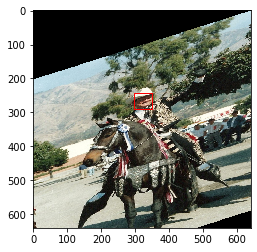

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


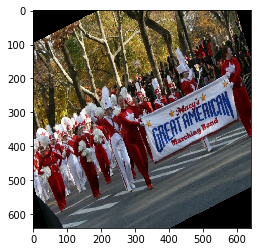

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


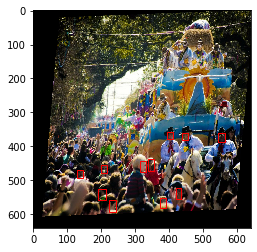

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


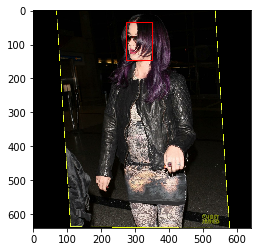

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


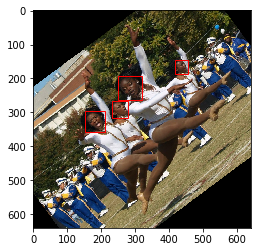

In [ ]:
import matplotlib.patches as patches

for idx, (image, labels) in enumerate(iter(training_dataset),1): #xmin,xmax,ymin,ymax
    print("+"*80)
    # print(labels)
    img = image
    img = img * 255
    img = tf.cast(img, tf.uint8)
    img = img.numpy()
    img_copy = np.copy(img)


    for i in labels:
        # print('%%%%%%%',i)
        xmin = i[0]
        xmax  = i[1]
        ymin = i[2]
        ymax = i[3]
        xmin,xmax,ymin,ymax = xmin.numpy(),xmax.numpy(),ymin.numpy(),ymax.numpy()
        # print("---------->",xmin,xmax,ymin,ymax)
        # cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,255), -1)
        plt.gca().add_patch(patches.Rectangle((xmin, ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none'))
        # x1,y1 ------
        # |          |
        # |          |
        # |          |
        # --------x2,y2

    # img =   cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()
    # cv2.imshow('Input', img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


    if idx%5==0:
        break
    